In [23]:
import torchvision
import torch
from torch import Tensor
from plots import plot_training_result, plot_image_data, plot_image_data_two

from vae.mnist_vae import VaeAutoencoderClassifier
from image_classifier.image_classifier import MNISTClassifier
from utils import frechet_inception_distance
from sampling import split_dirichlet

In [62]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())
print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0   # normalizing necessary to make pixels in [0, 1] range for FID
labels = training_data.targets[:60000]

batch_size = 100
alpha = 5000
epochs = 20

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


In [63]:
# Train VAE
vae = VaeAutoencoderClassifier(dim_encoding=2)

# alpha value of 5000 and 20 epochs seems to be the best
# increasing alpha will decrease KL divergence loss but worse generated data
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae.train_model(
    training_data,
    batch_size=batch_size,
    alpha=alpha,
    epochs=epochs
)

# # example of how to later aggregate weights and bias
# vae2 = VaeAutoencoderClassifier(dim_encoding=2)
# avg_parameter = torch.nn.Parameter((vae.encoder.fc1.weight + vae2.encoder.fc1.weight) / 2)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10
Finished epoch:  11
Finished epoch:  12
Finished epoch:  13
Finished epoch:  14
Finished epoch:  15
Finished epoch:  16
Finished epoch:  17
Finished epoch:  18
Finished epoch:  19
Finished epoch:  20


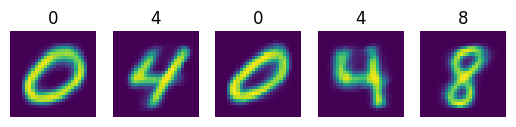

In [67]:
# plot generated data
image_tensor, label_tensor = vae.generate_data(n_samples=5)
plot_image_data(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

In [68]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


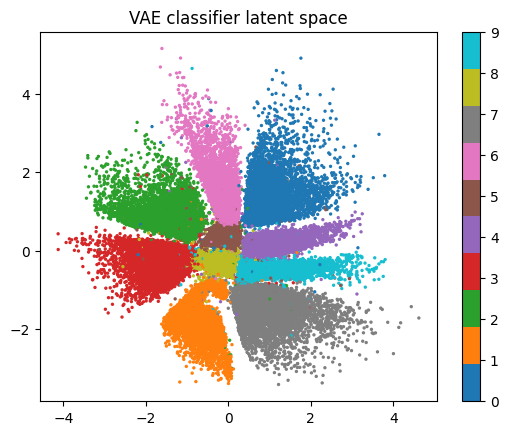

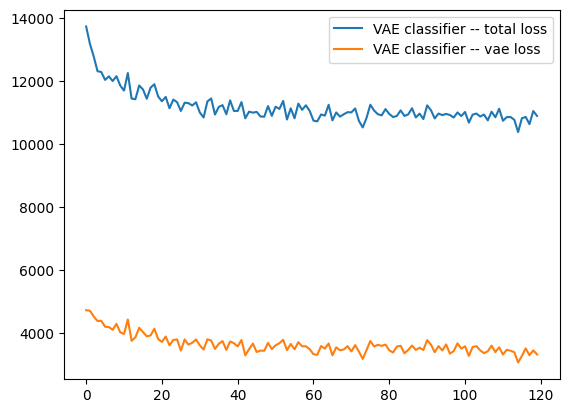

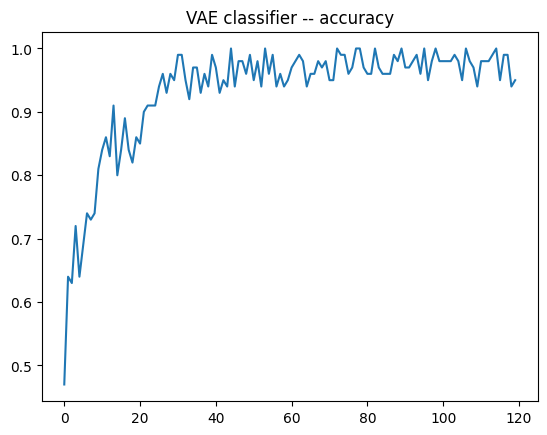

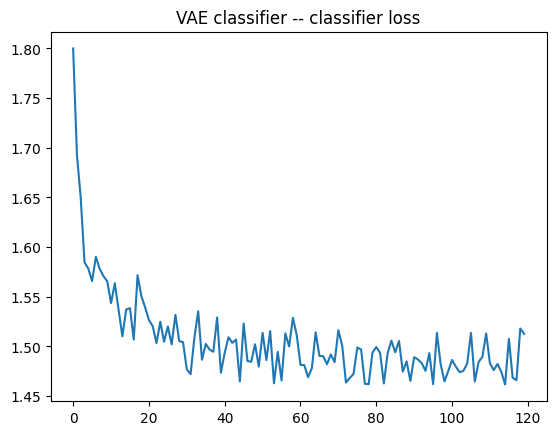

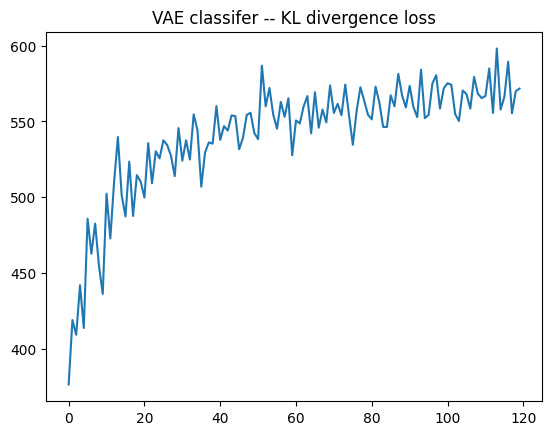

In [69]:
# plot results
plot_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [70]:
# train classifier for performance evaluation

classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=100, epochs=5)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Test accuracy:  0.9775


In [71]:
x, y = vae.generate_data(n_samples=10000)

assert x.shape[0] == y.shape[0]
print("Number of images: ", x.shape[0])

Number of images:  10000


In [72]:
# test image classification with gen images
accuracy = classifier.test_model_syn_img(x, y)
print("Accuracy: ", accuracy)

Accuracy:  0.9493


In [42]:
# compute FID score
syn_input, _ = vae.generate_data(n_samples=500)
input = input[:500]

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score (worst: 131, best: 85)
# 0 score only possible if absolutely identical
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

KeyboardInterrupt: 

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10
Finished epoch:  11
Finished epoch:  12
Finished epoch:  13
Finished epoch:  14
Finished epoch:  15
Finished epoch:  16
Finished epoch:  17
Finished epoch:  18
Finished epoch:  19
Finished epoch:  20
Input counts:  [5227, 2518, 475, 24, 542, 822, 2394, 1472, 437, 316]
Generated counts:  [4296, 2492, 868, 0, 338, 620, 2453, 1939, 435, 786]


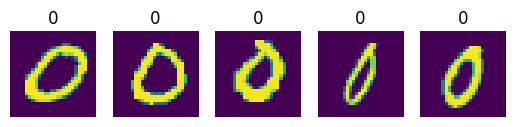

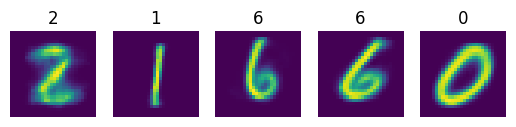

In [73]:
# generate imbalanced data set for comparison of distribution of input vs distribution of generated images
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:60000]
labels = training_data.targets[:60000]

users_data = split_dirichlet(dataset=training_data, num_users=4, is_cfar=False, beta=0.5)

total_input = []
total_labels = []
total_counts = []
for user_idx in users_data:
    images = []
    outputs = []
    counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    for data_idx in users_data[user_idx]:
        image = input[int(data_idx)]
        images.append(image)
        label = labels[int(data_idx)]
        outputs.append(label)
        counts[label] +=1
    total_input.append(images)
    total_labels.append(outputs)
    total_counts.append(counts)

user_idx = 0
sample_input = total_input[user_idx]
sample_label = total_labels[user_idx]

# print(sample_input)
# print(total_labels[user_idx])

input_tensor = torch.stack(sample_input)
label_tensor = torch.stack(sample_label)

plot_image_data_two(input_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

assert input_tensor.shape[0] == label_tensor.shape[0]

training_data.data = input_tensor
training_data.targets = label_tensor

assert training_data.data.shape == input_tensor.shape
assert training_data.targets.shape == label_tensor.shape


# Train VAE on imbalanced dataset
vae_imbalanced = VaeAutoencoderClassifier(dim_encoding=2)

# sufficient epoch makes the generated data distribution similar to the given input
# optimal so far is 50, 2000, 20
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae_imbalanced.train_model(
    training_data,
    batch_size=30,
    alpha=2000,
    epochs=20
)

gen_image, gen_output = vae_imbalanced.generate_data(n_samples=sum(total_counts[user_idx]))
gen_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for probabilities in gen_output:
    max_index = torch.argmax(probabilities)
    gen_counts[max_index]+=1

# plot generated data
plot_image_data(gen_image.cpu().detach().numpy(), gen_output.cpu().detach().numpy())

print("Input counts: ", total_counts[user_idx])
print("Generated counts: ", gen_counts)